# Stock Market Prediction

For people who invest in the stock market, they know it is a risky business. Whether you are passive investing or day trading for a living, the risk never goes away. Yet with advancements within the technology sector there are more tools to help assist when making such important investment decisions. For investors who are looking for a resource to help them with their investing, these time series models will help in giving an insight to the market. The stocks selected to be viewed at are within the QQQ ETF. We will looking at and forecasting values on the top 10 stocks within the QQQ ETF. 

## Import modules 

In [1]:
import yfinance as yf
import pandas_datareader as pdr
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import kpss
from sklearn.metrics import mean_squared_error
from prophet import Prophet
import cufflinks as cf
from sklearn.metrics import mean_absolute_percentage_error
cf.go_offline()

## Data Collection and EDA QQQ ETF

For the stock selection we will be looking at the top 10 stocks held in the QQQ ETF

In [4]:
df_QQQ = pd.read_csv(r"C:\Users\ronak\OneDrive\Desktop\stock-prediction-capstone\data\QQQ-holdings.csv")

In [5]:
df_QQQ

,Holding,Symbol,Weighting
0,Apple Inc.,AAPL,11.01%
1,Microsoft Corporation,MSFT,10.36%
2,"Amazon.com, Inc.",AMZN,7.74%
3,Tesla Inc,TSLA,4.7%
4,Alphabet Inc. Class C,GOOG,4.12%
...,...,...,...
98,Trip.com Group Ltd. Sponsored ADR,TCOM,0.12%
99,Check Point Software Technologies Ltd.,CHKP,0.11%
100,Incyte Corporation,INCY,0.1%
101,Fox Corporation Class A,FOXA,0.1%


# Sector Breakdown

In [6]:
df_QQQ_weight = {'Sector': ['Information Technology', 'Communication Services', 'Consumer Discretionary', 'Health Care', 'Consumer Staples', 'Industrials & Utilities'], 'Percentage': [48.82, 19.53, 17.42, 6.7, 4.84, 2.6]}

In [7]:
df_QQQ_weight = pd.DataFrame(data=df_QQQ_weight)

In [8]:
df_QQQ_weight[0:10].iplot(kind='pie', labels='Sector', values='Percentage', textinfo='label')

From the pie chart above it is clear that information technology is the leading sector within the ETF. IT inlcudes mostly all technology companies. Due to this the QQQ is often referred to as a guide to gauge how the technlology sector is performing.

# Holdings Breakdown

In [9]:
df_QQQ_plot = df_QQQ[['Symbol', 'Weighting']]

In [10]:
df_QQQ_plot['Weighting'] = list(map(lambda x: x[:-1], df_QQQ_plot['Weighting'].values))
df_QQQ_plot['Weighting'] = [float(x) for x in df_QQQ_plot['Weighting'].values]

### Plotting the top holdings within the ETF

In [11]:
df_QQQ_plot.iplot(kind='bar',x='Symbol', y='Weighting', title='QQQ ETF Holdings Weight', theme='space')

### Plotting the top 10 holdings within the ETF

In [12]:
df_QQQ_plot[0:10].iplot(kind='pie', labels='Symbol', values='Weighting', textinfo='label')

From this pie chart it explains that the top 10 weighted stocks within the ETF are all technology stocks. 
The list is: Apple, microsoft, amazon, tesla, google('A'), google('C'), nvidia, facebook, paypal, and netflix
This makes sense as the leading sector within the ETF is technology. For this project we will be looking at these top 10 stocks.

***

## Stock Data Collection and Manipulation

The data is collected from the Yahoo finance API which allows for historical data to be collected. The columns include the high, low, close, volume, dividends and stock splits

In [13]:
def get_finance_data(stock):
    s = yf.Ticker(stock)
    
    df = s.history(start = '2009-01-31', end='2021-10-22', interval = "1d")
    df = df.drop(['Dividends', 'Stock Splits'], axis=1)

    return df

In [14]:
aapl = get_finance_data('aapl')

In [15]:
aapl

,Open,High,Low,Close,Volume
Date,,,,,
2009-02-02,2.732241,2.821168,2.726107,2.806143,558247200
2009-02-03,2.818715,2.863486,2.768425,2.851220,599309200
2009-02-04,2.858579,2.951493,2.854899,2.868698,808421600
2009-02-05,2.844779,2.982158,2.840180,2.957933,749246400
2009-02-06,2.975106,3.066488,2.974493,3.057902,687209600
...,...,...,...,...,...
2021-10-15,143.770004,144.899994,143.509995,144.839996,67885200
2021-10-18,143.449997,146.839996,143.160004,146.550003,85589200
2021-10-19,147.009995,149.169998,146.550003,148.759995,76378900


A new dataframe is created to just include the closing prices

In [16]:
aapl_close = aapl[['Close']]

## Data Visualization

A graph is created to display the prices of AAPL stock from the data collected

In [17]:
aapl_close.iplot(title='Stock Close Prices', fill = True, xTitle='Dates',yTitle='Close Prices', theme='space')

This graph below shows the volume of the stock or the amount of shares that were traded

In [18]:
aapl['Volume'].iplot(title='Volume', xTitle='Dates', yTitle='Volume', theme='space')

# Time Series Data

## Plotting the rolling mean and rolling std

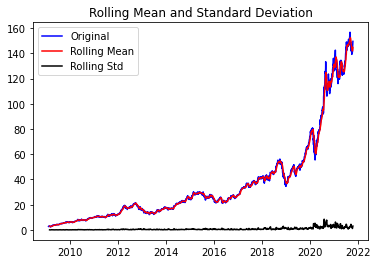

Results of dickey fuller test
Test Statistics                   2.825782
p-value                           1.000000
No. of lags used                 27.000000
Number of observations used    3176.000000
critical value (1%)              -3.432411
critical value (5%)              -2.862450
critical value (10%)             -2.567255
dtype: float64


In [17]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(aapl_close)

From the graph above it is evident that the data is non-stationary as there is an increasing mean throughout the plot

## Plotting the trend and seasonality

<Figure size 432x288 with 0 Axes>

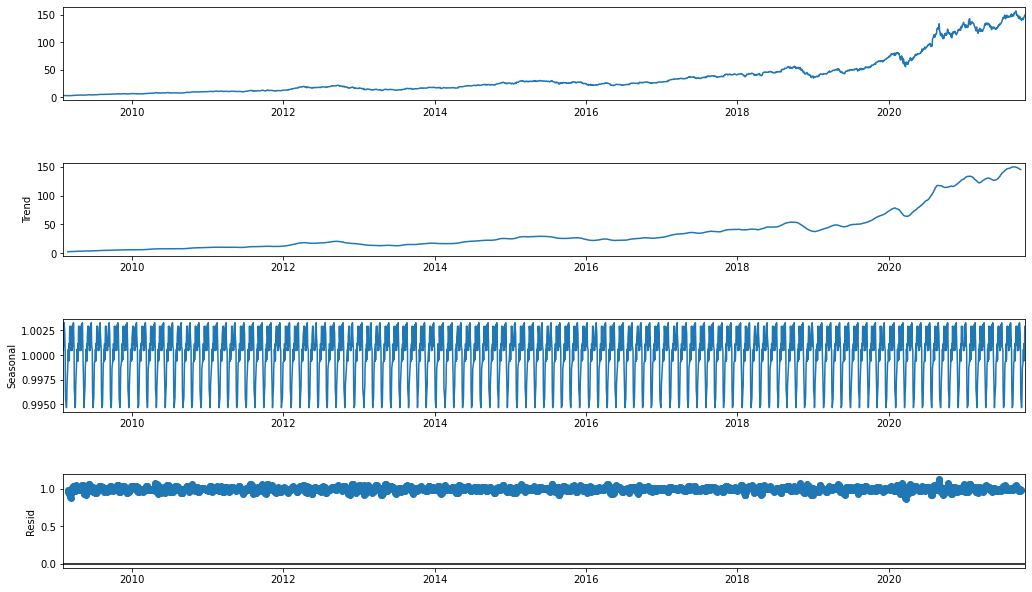

In [18]:
result = seasonal_decompose(aapl_close, model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

The plots above show that there is seasonality within the data which is another indicator that this data is not stationary

## Time Series Data Manipulation

In [19]:
aapl_close

,Close
Date,
2009-02-02,2.806142
2009-02-03,2.851220
2009-02-04,2.868699
2009-02-05,2.957933
2009-02-06,3.057902
...,...
2021-10-15,144.839996
2021-10-18,146.550003
2021-10-19,148.759995


## ADF Test

Check for stationary series using the Augmented Dickey Fuller Test.
The ADF test indicates whether or not differencing has to be done or not
- The null hypothesis of this test is that the time series is non-stationary. If the p-value of the test is less than 0.05 then you reject the null hypothesis and then make the statement that the data is stationart

In [20]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(aapl_close.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 2.825782
p-value: 1.000000


From this adf test, the p-value is well above 0.05 so we have to difference the data

## Differencing Term (d)

Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

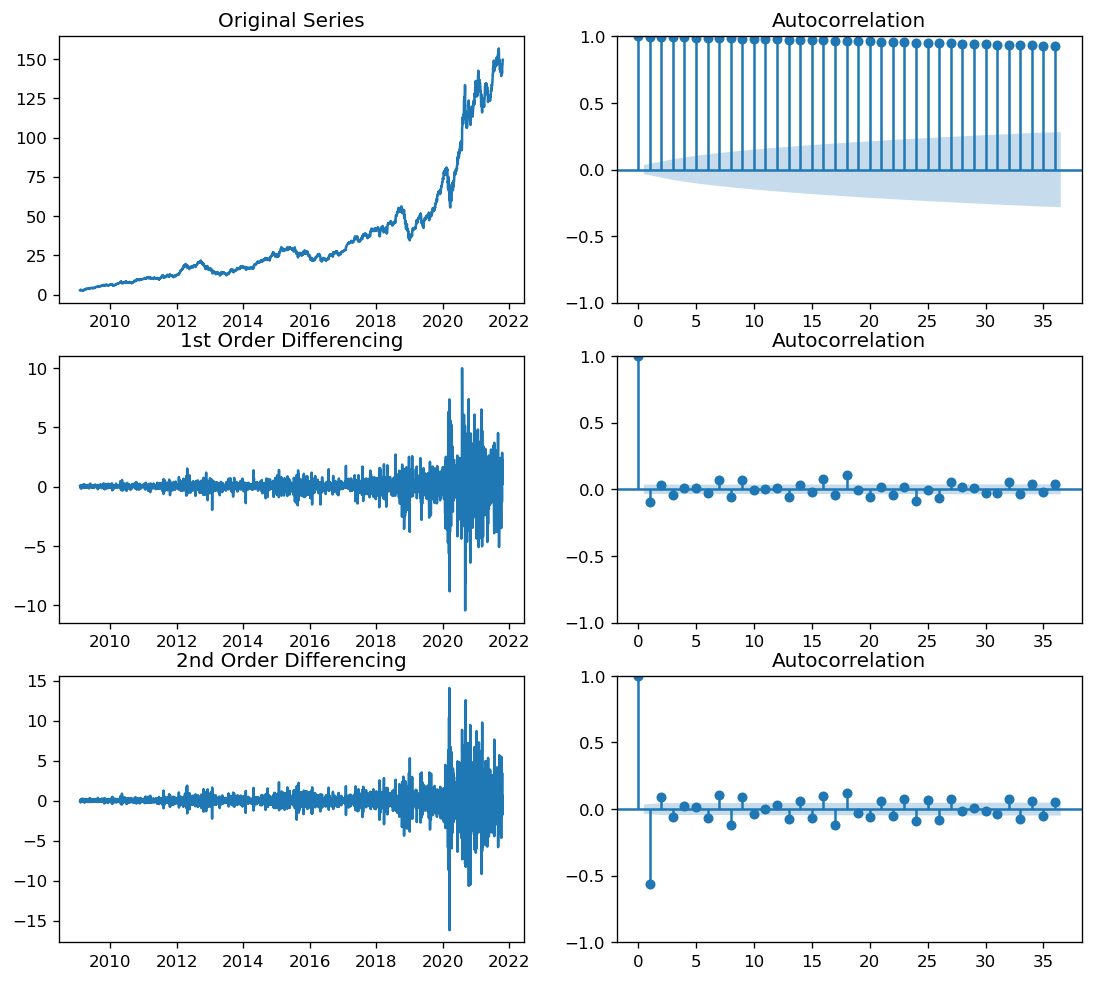

In [21]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(aapl_close); axes[0, 0].set_title('Original Series')
plot_acf(aapl_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(aapl_close.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(aapl_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(aapl_close.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(aapl_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced

## AR term (p)

The p term is used to remove any autocorrelation in a stationarized series. To figure out how much p we need, we can look at the PACF plot. The plot conveys the correlation between a lag and the series. We take the order of p to be the same as many lags that cross the significance level

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



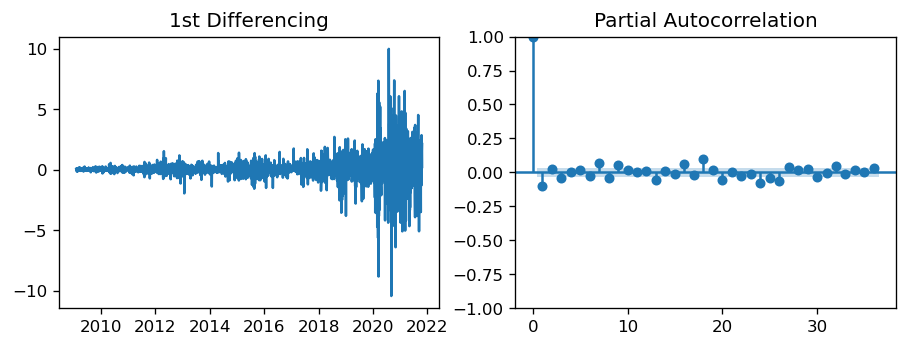

In [126]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(aapl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(aapl_close.diff().dropna(), ax=axes[1])

plt.show()

ACF lag 1 is quite significantly well above the significance line, that is why the lag term will be closer to 1

## MA Term (q)

THe q term is usually referred to the error of the lagged forecast. This term also removes autocorrelation in the stationarized series. The acf plot is looked at in order to figure out the terms for q

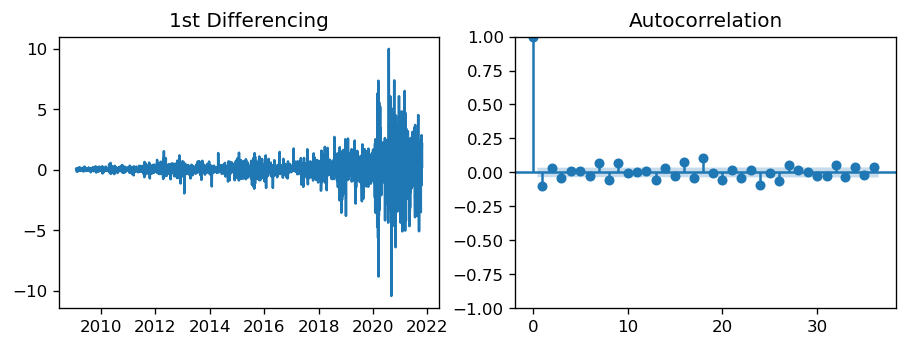

In [127]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})


fig, axes = plt.subplots(1, 2)
axes[0].plot(aapl_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(aapl_close.diff().dropna(), ax=axes[1])

plt.show()

The 1st lag is well above the signifigance line so the q term will be set to 1

# ARIMA Model

The first to do is split the data to train and test which will be used later in pmdarima

## Train-Test Split

In [128]:
n = int(len(aapl_close) * 0.80)
train = aapl_close[:n]
test = aapl_close[n:]

In [129]:
train

,Close
Date,
2009-02-02,2.806143
2009-02-03,2.851220
2009-02-04,2.868698
2009-02-05,2.957933
2009-02-06,3.057901
...,...
2019-04-02,47.358532
2019-04-03,47.683170
2019-04-04,47.766159


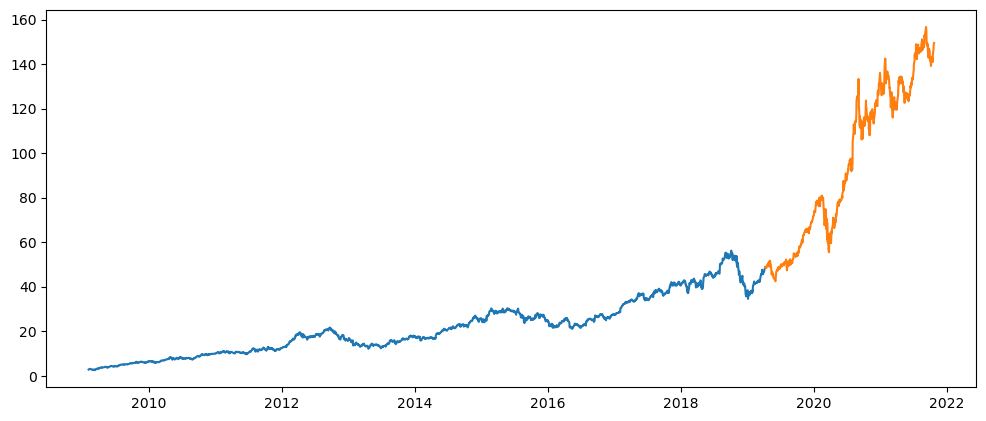

In [130]:
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')

The train data goes upto 2019-04-08 and the test data starts from 2019-04-09

## Prediction

In order to get the order of our arima model we take the terms that were figured out from before d = 1, q = 1, p = 1

In [160]:
model = SARIMAX(aapl_close, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\ronak\Anaconda3\envs\capstone\lib\site-packages\statsmodels\tsa\base\tsa_model.py:593: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 3204
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -4474.582
Date:                Wed, 27 Oct 2021   AIC                           8955.164
Time:                        13:22:06   BIC                           8973.380
Sample:                             0   HQIC                          8961.694
                               - 3204                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4451      0.056     -7.992      0.000      -0.554      -0.336
ma.L1          0.3534      0.058      6.080      0.000       0.239       0.467
sigma2         0.9571      0.007    137.860      0.0

We check for the residuals to make sure there are no patterns and there is a constant mean

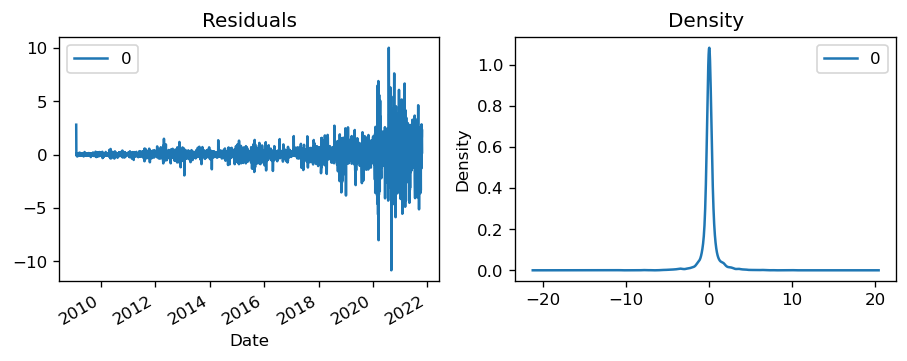

In [132]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

### Prediciting on the test set

In [133]:
pred = model_fit.predict(start=pd.to_datetime('2019-04-08'), dynamic=False)
plt.show()

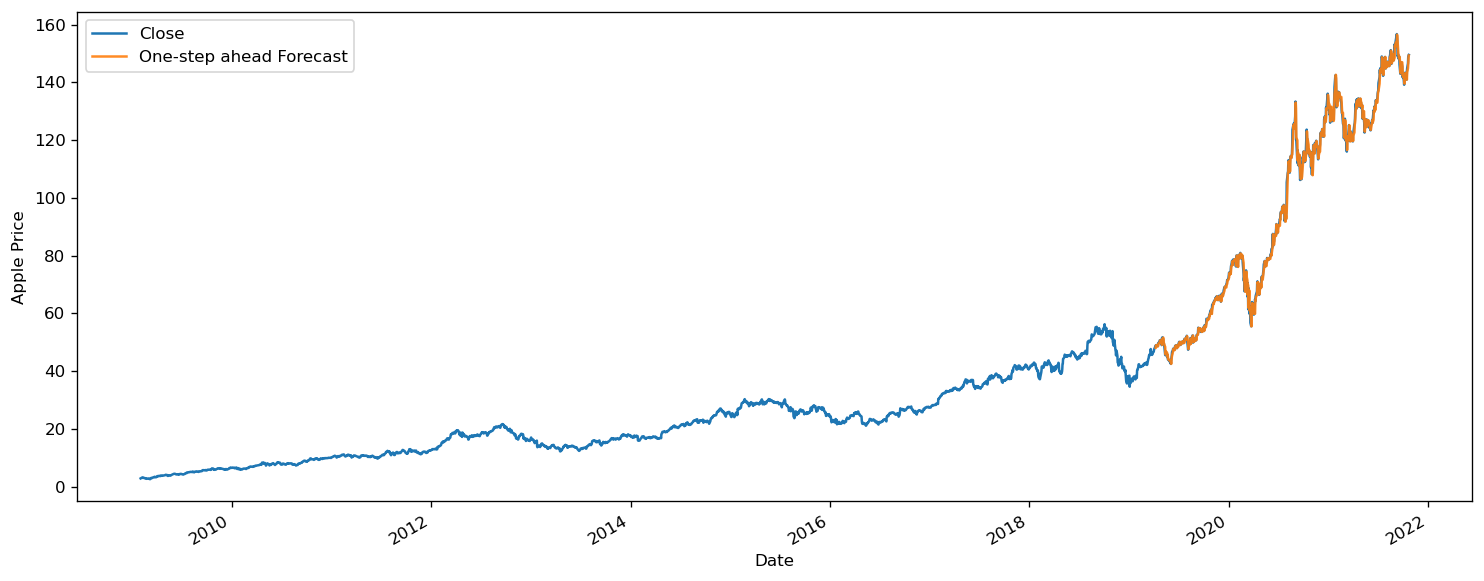

In [134]:
rcParams['figure.figsize'] = 15, 6

# Plot observed values
ax = aapl_close.plot(label='observed')

# Plot predicted values
pred.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Apple Price')
plt.legend()

plt.show();

After plotting the forecasting on the test set we are able to calculate the rmse(root mean squared error) and mape(mean absolute percentage error)

In [135]:
value_forecasted = pred
value_truth = aapl_close['Close']['2019-04-08':]

# Compute the root mean square error
mse = ((value_forecasted - value_truth) ** 2).mean()
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of prediction is 2.03


In [136]:
mean_absolute_percentage_error(value_truth, value_forecasted)

0.014982886618831548

The rmse provides the value of how much the closing price can be off by, the mape just calculates the percentage of that value. We got an mape of 1% which is very good as it is close to 0

# PMDARIMA 

This library is used for finding the best order of the ARIMA model. It is an equivalent to the R's autoarima|

In [137]:
import pmdarima as pm
from pmdarima.arima import ndiffs
from pmdarima.metrics import smape

The test done below tests for the difference

In [138]:
kpss_diffs = ndiffs(train, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(train, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

print(f"Estimated differencing term: {n_diffs}")
# Estimated differencing term: 1

Estimated differencing term: 1


In [139]:
auto = pm.auto_arima(train, d=n_diffs, seasonal=False, stepwise=True,
                     suppress_warnings=True, error_action="ignore", max_p=6,
                     max_order=None, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2577.466, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2578.559, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2578.468, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2580.635, Time=0.16 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2579.032, Time=0.81 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 4.643 seconds


In [140]:
print(auto.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2563
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1286.733
Date:                Wed, 27 Oct 2021   AIC                           2577.466
Time:                        12:06:40   BIC                           2589.163
Sample:                             0   HQIC                          2581.707
                               - 2563                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0180      0.008      2.246      0.025       0.002       0.034
sigma2         0.1599      0.002     95.244      0.000       0.157       0.163
Ljung-Box (L1) (Q):                   0.91   Jarque-

From the autoarima it gave an order of (0,1,0), it is then forecasted onto the test set as it was done before with our own choice of terms

In [141]:
model = auto  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 4.184429881834128
SMAPE: 1.514477333037325


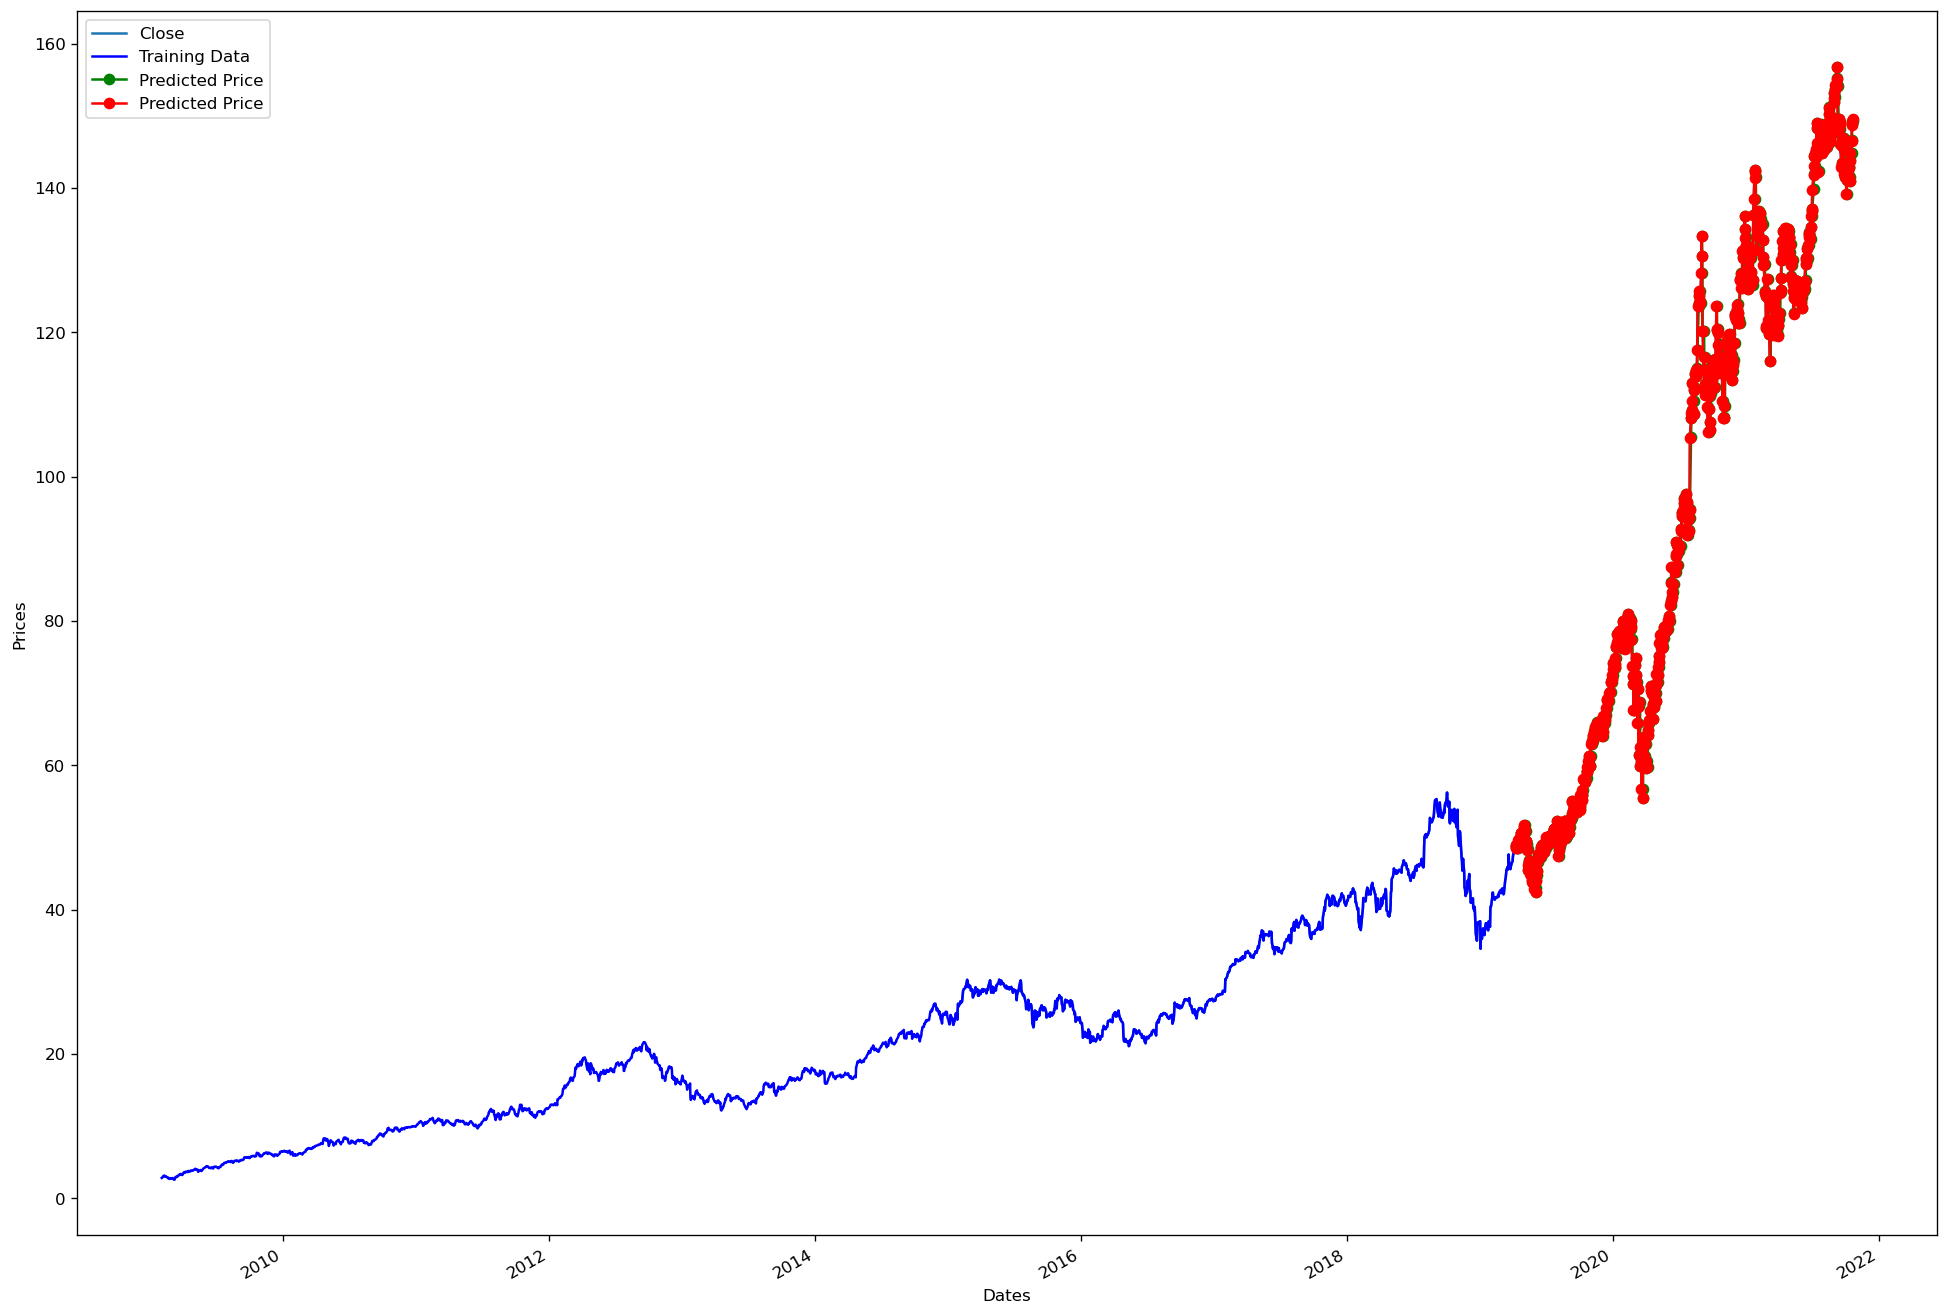

In [142]:
ax = aapl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [143]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(4.18443071392273), 2)))

The Root Mean Squared Error of prediction is 2.05


The autoarima gave essentially the same answer with just a difference of .02 which is insignificant.

## SARIMAX PMDARIMA

The SARIMAX model will check the ARMIA model with seasonality

In [144]:
smodel = pm.auto_arima(train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=6.79 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=8930.643, Time=0.22 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=3578.034, Time=2.50 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=6626.813, Time=3.04 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=8984.353, Time=0.17 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=4191.592, Time=0.89 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=3304.695, Time=9.17 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=27.79 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=9.16 sec
 ARIMA(0,0,0)(2,1,0)[12] intercept   : AIC=8883.915, Time=3.26 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=3299.145, Time=12.88 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=3576.829, Time=3.25 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=inf, Time=34.87 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=10.98 sec
 ARIMA(3,0,0)(2,1,0)[12] intercept   : A

In [145]:
model = smodel  # seeded from the model we've already fit

def forecast_one_step():
    fc, conf_int = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0])

forecasts = []
confidence_intervals = []

for new_ob in test['Close']:
    fc, conf = forecast_one_step()
    forecasts.append(fc)
    confidence_intervals.append(conf)

    # Updates the existing model with a small number of MLE steps
    model.update(new_ob)

print(f"Mean squared error: {mean_squared_error(test['Close'], forecasts)}")
print(f"SMAPE: {smape(test['Close'], forecasts)}")

Mean squared error: 5.531730410125347
SMAPE: 1.7790189770534313


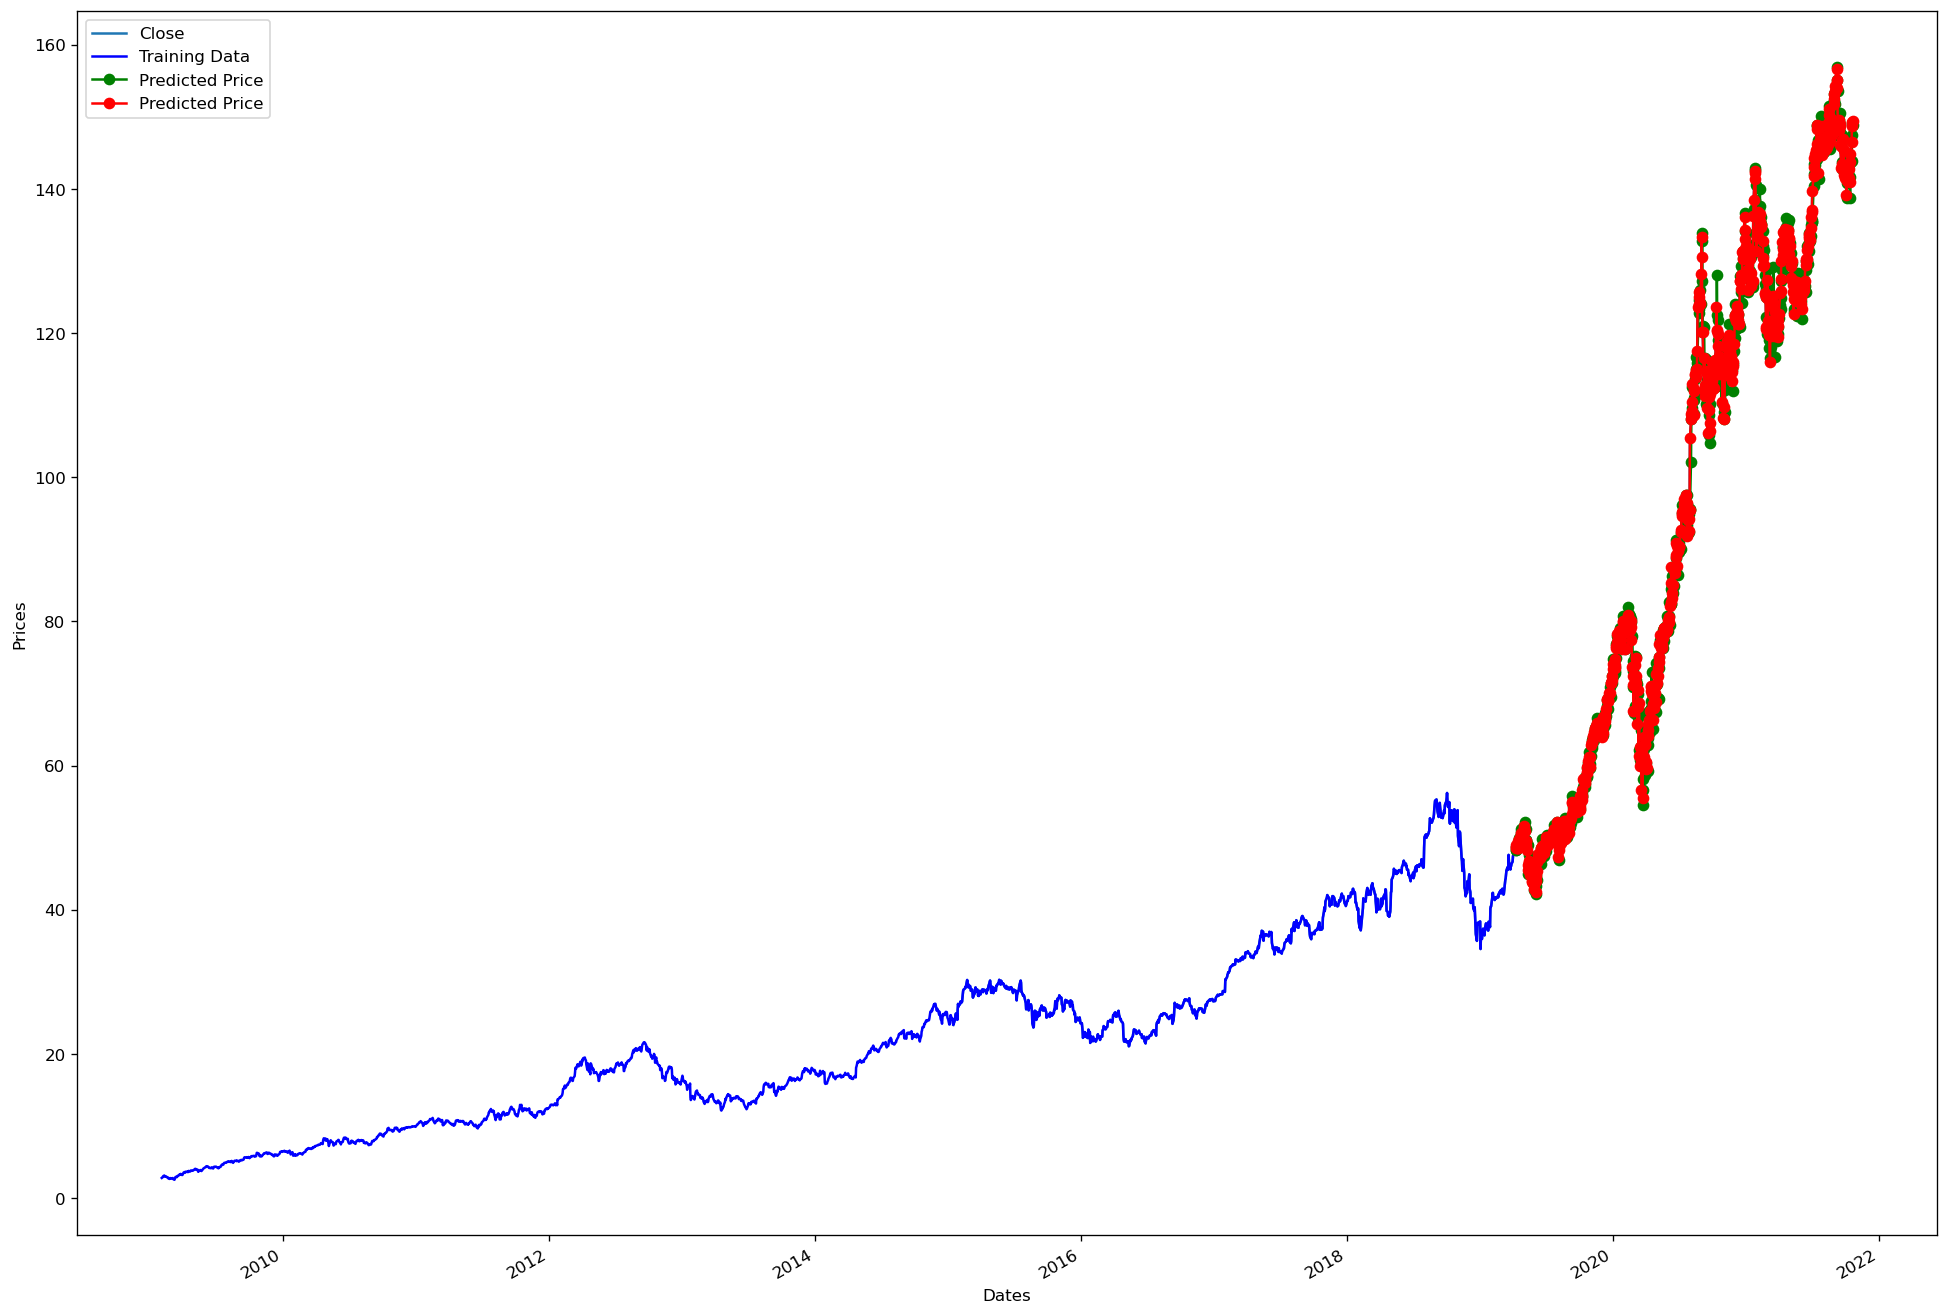

In [146]:
ax = aapl_close.iloc[1500:].plot(label='observed', figsize=(20, 15))
ax.plot(train, color='blue', label='Training Data')
ax.plot(test.index, forecasts, color='green', marker='o',
             label='Predicted Price')
ax.plot(test.index, test, color='red', marker='o', label='Predicted Price')
ax.set_xlabel('Dates')
ax.set_ylabel('Prices')
#axes[0].plot(test_data.index, forecasts, color='green', marker='o',
       #      label='Predicted Price')

plt.legend()
plt.show()

In [147]:
print('The Root Mean Squared Error of prediction is {}'.format(round(np.sqrt(5.53191466565251), 2)))

The Root Mean Squared Error of prediction is 2.35


After the modeling with SARIMAX we got a rmse of 2.35 which is more than our other two models, so for the correct prediction we will be using the ARIMA model order as it gave a lower rmse value

## FB PROPHET
Prophet is a time series forecasting library released by Facebook to make the process much easier

In order to use prophet we need to reconfigure the data to have the date and close price as just columns

In [148]:
aapl_close =aapl[['Close']]

In [149]:
aapl = aapl_close.reset_index()

Then we turn both the columns into 'y' and 'ds'

In [151]:
aapl.rename(columns={'Close': 'y', 'Date': 'ds'},inplace=True)
aapl['ds'] = pd.to_datetime(aapl['ds'])
aapl['y']=aapl['y'].astype(float)

## Predicting with Prophet

In [169]:
df_prophet = Prophet(daily_seasonality=True)
df_prophet.fit(aapl)

We are going to also be forecasting a year into the future

In [170]:
fcast_time=365   # 1 year
df_forecast = df_prophet.make_future_dataframe(periods= fcast_time, freq='D')
df_forecast.tail(10)

,ds
3559,2022-10-12
3560,2022-10-13
3561,2022-10-14
3562,2022-10-15
3563,2022-10-16
3564,2022-10-17
3565,2022-10-18
3566,2022-10-19
3567,2022-10-20
3568,2022-10-21


The model now predicts on the forecast value and we see the plot below

In [171]:
# Forecasting - call the method predict
df_forecast = df_prophet.predict(df_forecast)

In [172]:
df_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3564,2022-10-17,198.560529,189.927159,207.388430
3565,2022-10-18,198.754227,190.291631,207.458360
3566,2022-10-19,198.917929,190.529123,207.324568
3567,2022-10-20,199.049429,189.987457,207.860637
3568,2022-10-21,199.118470,190.853517,208.169994


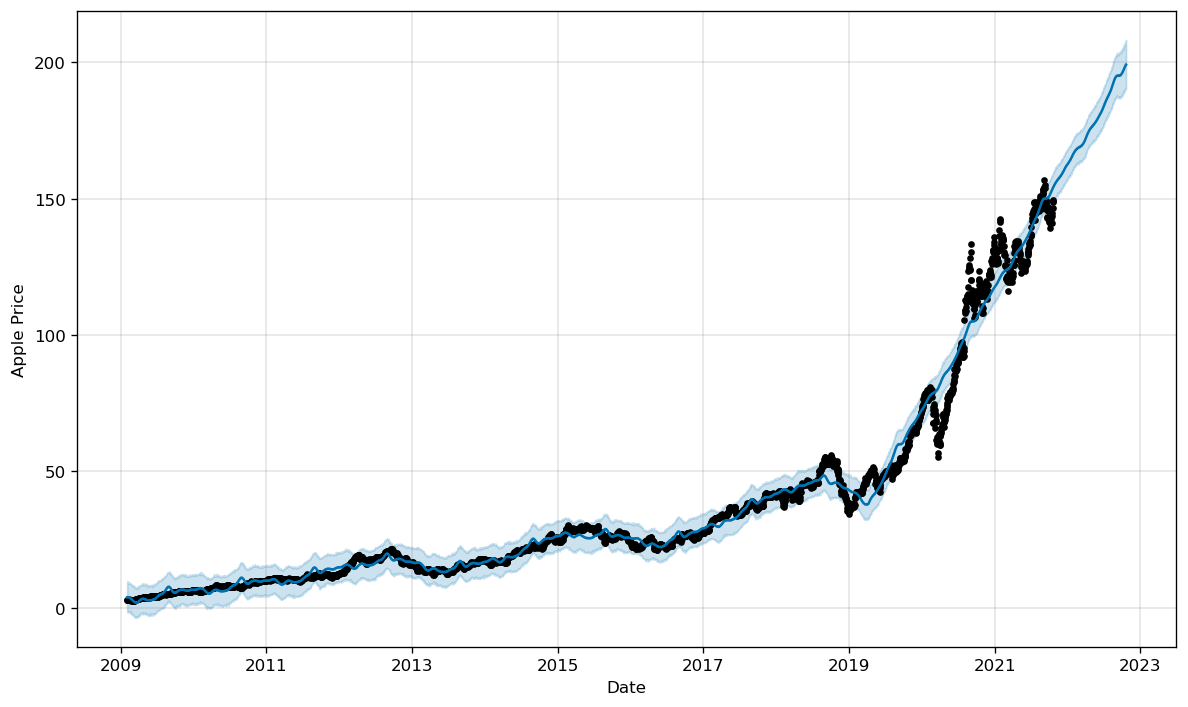

In [173]:
df_prophet.plot(df_forecast, xlabel = 'Date', ylabel = 'Apple Price');

We can also show the forecast components weekly, daily, and yearly

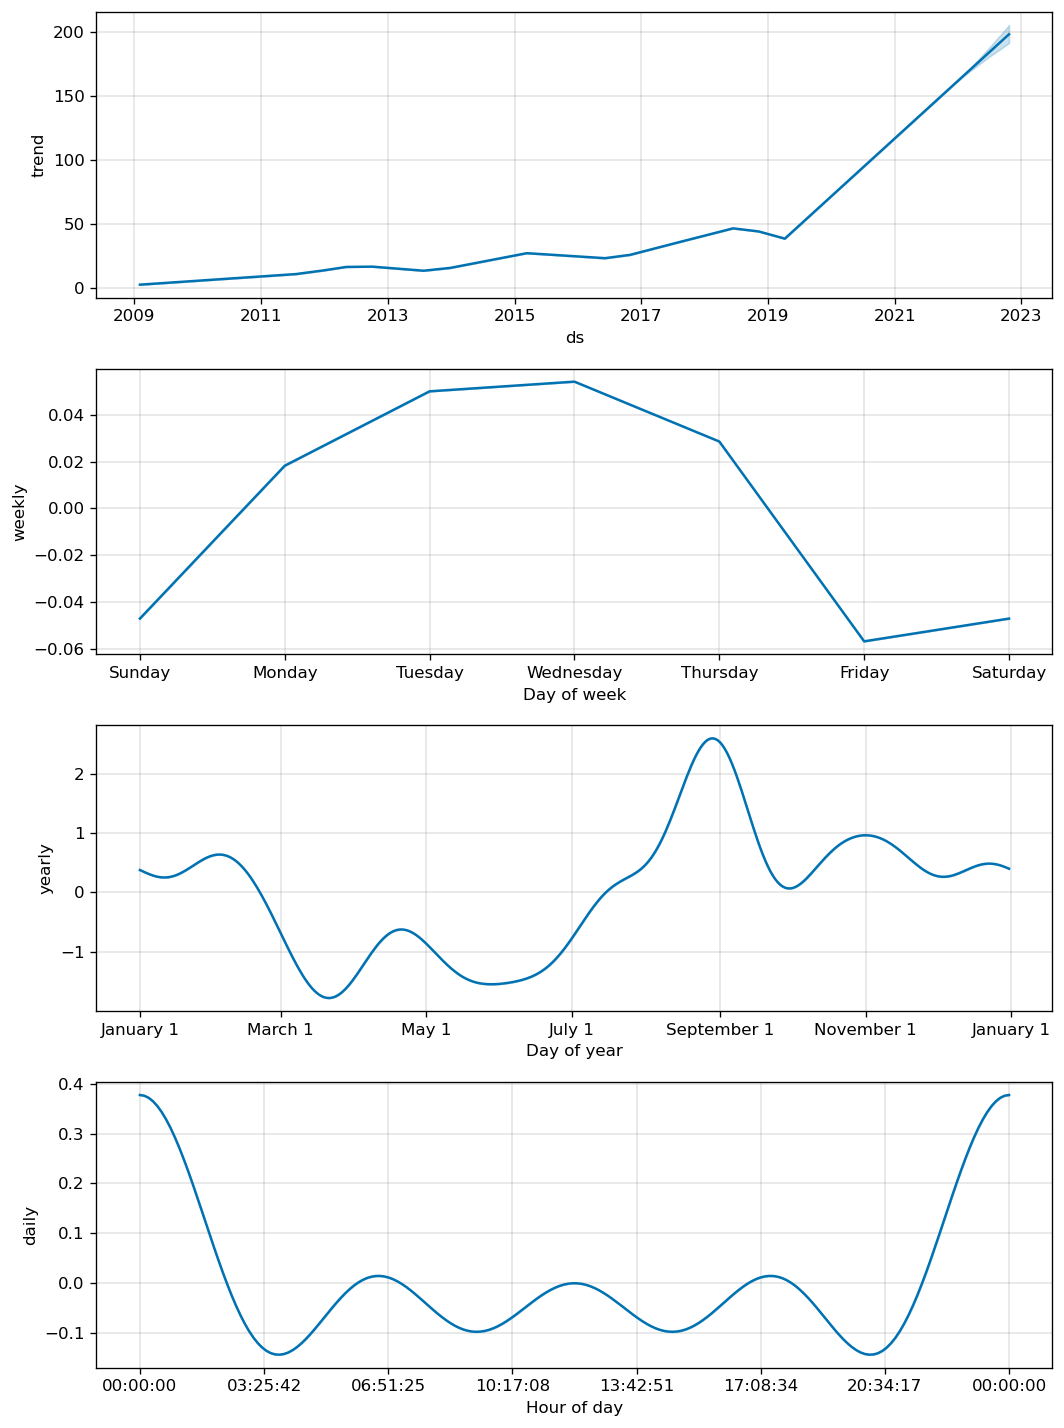

In [174]:
fig2 = df_prophet.plot_components(df_forecast)
plt.show()

In order to find the error values like before we have to use cross-validation with prophet

In [175]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(df_prophet, horizon = '365 days')

INFO:prophet:Making 18 forecasts with cutoffs between 2012-04-23 12:00:00 and 2020-10-21 00:00:00
100%|██████████| 18/18 [02:43<00:00,  9.11s/it]


In [176]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,49.121794,7.008694,4.686740,0.116379,0.118512,0.118717,0.175727
1,37 days 00:00:00,50.318368,7.093544,4.756898,0.117770,0.120035,0.120203,0.168142
2,37 days 12:00:00,50.036685,7.073661,4.763893,0.118503,0.121338,0.120936,0.166561
3,38 days 00:00:00,50.463659,7.103778,4.802529,0.119540,0.121525,0.121936,0.161820
4,38 days 12:00:00,50.104713,7.078468,4.794944,0.119960,0.122123,0.122273,0.161188


With cross-validation we see that we get a rmse of around $7 and close to 11-12%

## Results

With the ARIMA and Pmdarima model we got an rmse of near 2.03 and 2.05 which is our lowest value. Then with the SARIMAX we got a rmse of 2.35 which is higher than the ARIMA models. And lastly we have the prophet which gave the highest rmse of 7. Due to these results the ARIMA model would be the best to use in order to predict the closing price of this stock